In [1]:
import numpy as np
mutated_data = np.load("/content/MUTATION_DATA_TRAINING_6000.npz", allow_pickle=True)
mutated_test = mutated_data['arr_0'][:1000]
output_test = "MUTATED_DATA_TEST_1000_6000"
np.savez_compressed(output_test, arr_0=np.array(mutated_test))
mutated_val = mutated_data['arr_0'][5000:]
output_val = "MUTATED_DATA_VAL_1000_6000"
np.savez_compressed(output_val, arr_0=np.array(mutated_val))
mutated_train = mutated_data['arr_0'][1000:5000]
output_train = "MUTATED_DATA_TRAIN_5000_6000"
np.savez_compressed(output_train, arr_0=np.array(mutated_train))



/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


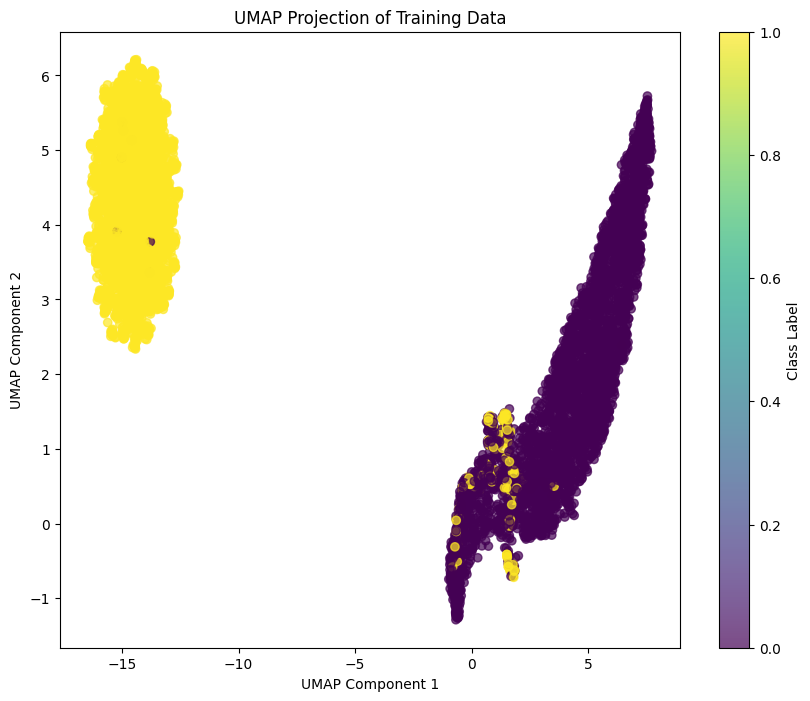

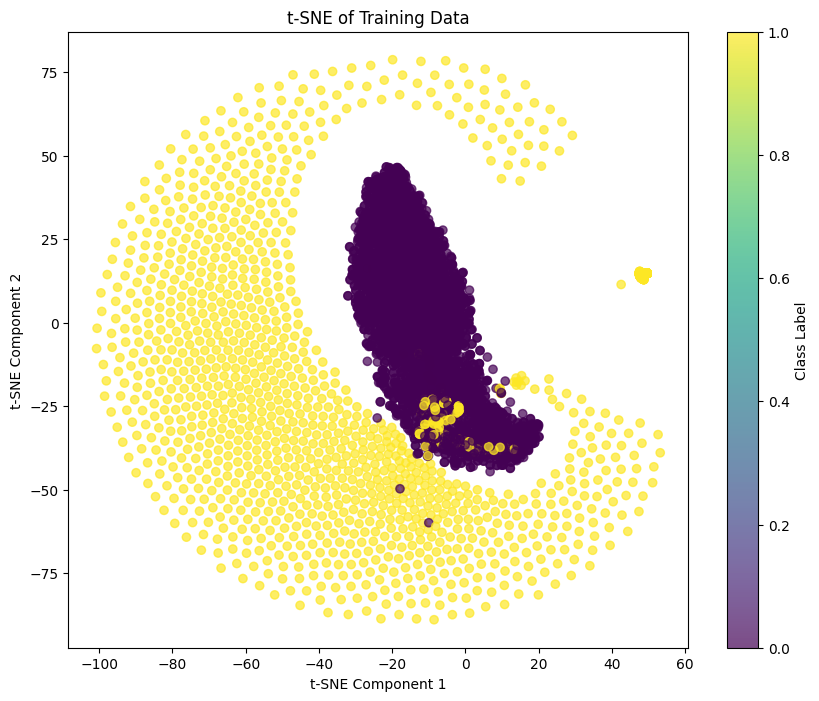

In [28]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import os
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, roc_auc_score
from tensorflow.keras import regularizers
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import umap.umap_ as umap
# Function to load sequences (unchanged)
def load_sequences(data):
    encoded_sequences = None
    for key in data.files:
        temp_sequences = data[key]
        if temp_sequences.ndim == 2:
            num_samples = temp_sequences.shape[0]
            sequence_length = temp_sequences.shape[1] // 4
            temp_sequences = np.expand_dims(temp_sequences, axis=1)
        if temp_sequences.ndim == 3:
            encoded_sequences = temp_sequences
            break
    return encoded_sequences

def load_sequences_with_shape(data):
    encoded_sequences = None
    for key in data.files:
        temp_sequences = data[key]
        if temp_sequences.ndim == 2:  # If 2D, reshape to 3D for LSTM
            temp_sequences = np.expand_dims(temp_sequences, axis=1)  # (samples, 1, features)
        if temp_sequences.ndim == 3:
            encoded_sequences = temp_sequences
            input_shape = input_shape=(encoded_sequences.shape[1], encoded_sequences.shape[2])
            break
    return encoded_sequences, input_shape



# Further loading of test, validation, and train data (unchanged)
mutated_test_1 = np.load("/content/MUTATED_DATA_TEST_1000_6000_TRUE_3.npz", allow_pickle=True)
mutated_test = load_sequences(mutated_test_1)
mutated_test_label = np.ones(mutated_test.shape[0])
mutated_test, mutated_test_label = shuffle(mutated_test, mutated_test_label, random_state=42)

mutated_val_1 = np.load("/content/MUTATED_DATA_VAL_1000_6000_TRUE_2.npz", allow_pickle=True)
mutated_val = load_sequences(mutated_val_1)
mutated_val_label = np.ones(mutated_val.shape[0])
mutated_val, mutated_val_label = shuffle(mutated_val, mutated_val_label, random_state=42)

mutated_train_1 = np.load("/content/MUTATED_DATA_TRAIN_5000_6000_TRUE_2.npz", allow_pickle=True)
mutated_train = load_sequences(mutated_train_1)
mutated_train_label = np.ones(mutated_train.shape[0])
mutated_train, mutated_train_label = shuffle(mutated_train, mutated_train_label, random_state=42)

nonmutated_test_1 = np.load("/content/AUGMENTED_DATA_TEST_1000_6000_TRUE1.npz", allow_pickle=True)
nonmutated_test = load_sequences(nonmutated_test_1)
nonmutated_test_label = np.zeros(nonmutated_test.shape[0])
nonmutated_test, nonmutated_test_label = shuffle(nonmutated_test, nonmutated_test_label, random_state=42)

nonmutated_val_1 = np.load("/content/AUGMENTED_DATA_TEST_VAL_1000_6000_TRUE1.npz", allow_pickle=True)
nonmutated_val = load_sequences(nonmutated_val_1)
nonmutated_val_label = np.zeros(nonmutated_val.shape[0])
nonmutated_val, nonmutated_val_label = shuffle(nonmutated_val, nonmutated_val_label, random_state=42)

nonmutated_train_1 = np.load("/content/AUGMENTED_DATA_TRAIN_5000_6000_TRUE1.npz", allow_pickle=True)
nonmutated_train = load_sequences(nonmutated_train_1)
nonmutated_train_label = np.zeros(nonmutated_train.shape[0])
nonmutated_train, nonmutated_train_label = shuffle(nonmutated_train, nonmutated_train_label, random_state=42)

# Combine the mutated and nonmutated data for training, validation, and testing (unchanged)
X_val = np.concatenate([mutated_val, nonmutated_val], axis=0)
y_val = np.concatenate([mutated_val_label, nonmutated_val_label], axis=0)
X_val, y_val = shuffle(X_val, y_val, random_state=1)

X_test = np.concatenate([mutated_test, nonmutated_test], axis=0)
y_test = np.concatenate([mutated_test_label, nonmutated_test_label], axis=0)
X_test, y_test = shuffle(X_test, y_test, random_state=1)

X_train = np.concatenate([mutated_train, nonmutated_train], axis=0)
y_train = np.concatenate([mutated_train_label, nonmutated_train_label], axis=0)
X_train, y_train = shuffle(X_train, y_train, random_state=1)
def apply_umap(X_train, X_val, X_test, n_components=2, n_neighbors=15, min_dist=0.1):
    # Reshape to 2D for UMAP
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Initialize UMAP model
    umap_model = umap.UMAP(n_components=n_components, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)

    # Fit on training data and transform
    X_train_umap = umap_model.fit_transform(X_train_flat)

    # Apply transformation to validation and test sets
    X_val_umap = umap_model.transform(X_val_flat)
    X_test_umap = umap_model.transform(X_test_flat)

    return X_train_umap, X_val_umap, X_test_umap

# Apply UMAP to training, validation, and test data
X_train_umap, X_val_umap, X_test_umap = apply_umap(X_train, X_val, X_test)

# Visualizing the UMAP results (for training data)
plt.figure(figsize=(10, 8))
plt.scatter(X_train_umap[:, 0], X_train_umap[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.colorbar(label='Class Label')  # This will show the color mapping to classes
plt.title("UMAP Projection of Training Data")
plt.xlabel("UMAP Component 1")
plt.ylabel("UMAP Component 2")
plt.show()
# Now applying PCA to the training, validation, and test data
def apply_tsne(X_train, X_val, X_test, n_components=2):
    # Apply t-SNE to the data
    tsne = TSNE(n_components=n_components, random_state=42)

    # For t-SNE, we typically flatten the data before applying it
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_val_flat = X_val.reshape(X_val.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    # Fit and transform training data
    X_train_tsne = tsne.fit_transform(X_train_flat)

    # Optionally transform validation and test data
    X_val_tsne = tsne.fit_transform(X_val_flat)
    X_test_tsne = tsne.fit_transform(X_test_flat)

    return X_train_tsne, X_val_tsne, X_test_tsne

# Apply t-SNE to training, validation, and test data
X_train_tsne, X_val_tsne, X_test_tsne = apply_tsne(X_train, X_val, X_test)

# Visualizing the t-SNE results (for training data)
plt.figure(figsize=(10, 8))
plt.scatter(X_train_tsne[:, 0], X_train_tsne[:, 1], c=y_train, cmap='viridis', alpha=0.7)
plt.colorbar(label='Class Label')  # This will show the color mapping to classes
plt.title("t-SNE of Training Data")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.show()

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Compute class weights for imbalanced dataset
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Print to verify
print("Class Weights:", class_weight_dict)

Class Weights: {0: 1.0, 1: 1.0}


In [15]:
import seaborn as sns
flat_control_data = nonmutated_val.flatten()
flat_mutated_data = mutated_val.flatten()

# Plotting histograms for comparison
plt.figure(figsize=(12, 6))

# Plot histogram for control data
plt.subplot(1, 2, 1)
sns.histplot(flat_control_data, bins=50, kde=True, color="blue")
plt.title("Control Data (Non-mutated)")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")

# Plot histogram for mutated data
plt.subplot(1, 2, 2)
sns.histplot(flat_mutated_data, bins=50, kde=True, color="red")
plt.title("Mutated Data")
plt.xlabel("Feature Values")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

KeyboardInterrupt: 

In [15]:
import numpy as np
import tensorflow as tf
import keras_tuner as kt
from sklearn.model_selection import KFold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

# Define k-folds
k = 5
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Define the model-building function
def rnn_model(hp, input_shape):
    model = Sequential([
        LSTM(hp.Int('lstm_units_1', min_value=32, max_value=128, step=32),
             input_shape=input_shape, return_sequences=True, activation="relu"),
        BatchNormalization(),
        LSTM(hp.Int('lstm_units_2', min_value=16, max_value=64, step=16), return_sequences=False, activation="relu"),
        Dense(8, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        Dropout(hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L2(0.01))
    ])

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

# Define the tuner
tuner = kt.Hyperband(
    lambda hp: rnn_model(hp, input_shape=(X_train_tsne.shape[1], 1)),  # Using lambda to pass input_shape
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir_5',
    project_name='rnn_tuning_cv'
)

# Store results from each fold
val_accuracies = []

# Perform k-fold cross-validation
for train_index, val_index in kf.split(X_train_tsne):
    print(f"\nTraining new fold...\n")

    # Split data
    X_train_fold, X_val_fold = X_train_tsne[train_index], X_train_tsne[val_index]
    y_train_fold, y_val_fold = y_train[train_index], y_train[val_index]

    # Run hyperparameter search for this fold
    tuner.search(X_train_fold, y_train_fold,
                 validation_data=(X_val_fold, y_val_fold),
                 epochs=10,
                 batch_size=16,
                 callbacks=[EarlyStopping(monitor='val_loss', patience=3)])

    # Get the best model for this fold
    best_model = tuner.get_best_models(num_models=1)[0]

    # Evaluate on validation fold
    _, val_acc = best_model.evaluate(X_val_fold, y_val_fold, verbose=0)
    val_accuracies.append(val_acc)

# Print average validation accuracy
print(f"\nAverage Validation Accuracy: {np.mean(val_accuracies)}")

# Get the best hyperparameters from all folds
best_hyperparameters = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:", best_hyperparameters.values)

# Train the final model using the best hyperparameters on the full training set
final_model = rnn_model(best_hyperparameters, input_shape=(X_train_tsne.shape[1], 1))
final_model.fit(X_train_tsne, y_train, epochs=10, batch_size=16)

# Evaluate on the test set
test_loss, test_accuracy = final_model.evaluate(X_test_tsne, y_test)
print(f"\nFinal Test Accuracy: {test_accuracy}")

# Save the final trained model
final_model.save('final_best_model.h5')


Trial 30 Complete [00h 00m 19s]
val_accuracy: 0.9674999713897705

Best val_accuracy So Far: 0.9674999713897705
Total elapsed time: 00h 05m 22s

Training new fold...


Training new fold...


Training new fold...


Training new fold...


Average Validation Accuracy: 0.9662499904632569
Best Hyperparameters: {'lstm_units_1': 32, 'lstm_units_2': 64, 'dropout_rate': 0.30000000000000004, 'learning_rate': 0.0005348989194905313, 'tuner/epochs': 10, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}
Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7754 - loss: 0.5823
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9448 - loss: 0.2752
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9529 - loss: 0.2341
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9522 - loss: 0.2208
Epoch 5/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9558 - loss: 0.2097
Epoch 6/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy


Final Test Accuracy: 0.597000002861023


In [49]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow import keras
def rnn_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True, activation="relu"),
        Dropout(0.3),
        LSTM(32, input_shape=input_shape, return_sequences=False, activation="relu", kernel_regularizer=regularizers.L2(0.001)),
        Dropout(0.3),
        Dense(8, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
        Dropout(0.5),
        Dense(4, activation='relu', kernel_regularizer=regularizers.L2(0.001)),
        Dropout(0.5),
        Dense(1, activation='sigmoid', kernel_regularizer=regularizers.L2(0.001))
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0), loss="binary_crossentropy", metrics=["accuracy"])
    return model
def reset_rnn(input_shape):
    # Recreate the model to reset weights
    model = rnn_model(input_shape)
    return model

# Train the model
checkpoint_path = "E:/my_models/6000_4_if_new_best_model.weights.h5"
shape = input_shape=(X_train_tsne.shape[1], 1)
model1 = reset_rnn(shape)

checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, verbose=1)
csv_logger = CSVLogger("training_log_6000_4.csv")

history = model1.fit(X_train_tsne, y_train, validation_data=(X_val_tsne, y_val),
                    epochs=20, batch_size=16, callbacks=[checkpoint, csv_logger])

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


488/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5486 - loss: 0.7522
Epoch 1: val_loss improved from inf to 0.66587, saving model to E:/my_models/6000_4_if_new_best_model.weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - accuracy: 0.5495 - loss: 0.7514 - val_accuracy: 0.7810 - val_loss: 0.6659
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6635 - loss: 0.6539
Epoch 2: val_loss improved from 0.66587 to 0.56971, saving model to E:/my_models/6000_4_if_new_best_model.weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.6635 - loss: 0.6539 - val_accuracy: 0.7620 - val_loss: 0.5697
Epoch 3/20
485/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7582 - loss: 0.5851
Epoch 3: val_loss improved from 0.56971 to 0.49234, saving model to E:/my_models/6000_4_if_new_best_model.weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7584 - loss: 0.5847 - val_accuracy: 0.7815 - val_loss: 0.4923
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - a

In [173]:

checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True, save_weights_only=True, verbose=1)
csv_logger = CSVLogger("training_log_6000_4.csv")

history = model1.fit(X_train_pca, y_train, validation_data=(X_val_pca, y_val),
                    epochs=10, batch_size=16, callbacks=[checkpoint, csv_logger])


# Evaluate the model
y_pred = model1.predict(X_test)
print(y_pred)
y_pred_classes = (y_pred > 0.5).astype("int32")
report = classification_report(y_test, y_pred_classes)
report_df = pd.DataFrame(report).transpose()

# Save the report to a CSV file
report_df.to_csv("6000_new_if_classification_report.csv")
# Evaluate model performance
print(report)
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.5f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Test Accuracy
loss, accuracy = model1.evaluate(X_test_tsne, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
predictions = model1.predict(X_test).flatten()
print("\n🔹 First 10 Predictions vs Actual Values 🔹")
for i in range(10):
    print(f"Sample {i+1}: Actual = {y_test[i]}, Predicted Probability = {predictions[i]:.4f}")

Epoch 1/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.5291 - loss: 0.8237
Epoch 1: val_loss improved from inf to 0.81124, saving model to E:/my_models/6000_4_if_new_best_model.weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 52s 98ms/step - accuracy: 0.5291 - loss: 0.8237 - val_accuracy: 0.5000 - val_loss: 0.8112
Epoch 2/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.5612 - loss: 0.7642
Epoch 2: val_loss improved from 0.81124 to 0.77280, saving model to E:/my_models/6000_4_if_new_best_model.weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 98ms/step - accuracy: 0.5612 - loss: 0.7642 - val_accuracy: 0.5000 - val_loss: 0.7728
Epoch 3/10
500/500 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.6579 - loss: 0.6305
Epoch 3: val_loss improved from 0.77280 to 0.67501, saving model to E:/my_models/6000_4_if_new_best_model.weights.h5
500/500 ━━━━━━━━━━━━━━━━━━━━ 49s 97ms/step - accuracy: 0.6580 - loss: 0.6304 - val_accuracy: 0.9990 - val_loss: 0.6750
Epoch 4/10
500/500 ━━━━━━━━━━━━━━━━

KeyboardInterrupt: 

In [31]:
model1.summary()

# Check regularizers applied to each layer:
for layer in model1.layers:
    if hasattr(layer, 'kernel_regularizer') and layer.kernel_regularizer is not None:
        print(f"Layer {layer.name} has regularizer: {layer.kernel_regularizer}")


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                       │ (None, 2, 32)               │           4,352 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_22 (Dropout)                 │ (None, 2, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_17 (LSTM)                       │ (None, 16)                  │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_23 (Dropout)                 │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_20 (Dense)                     │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 4)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 22,997 (89.84 KB)

 Trainable params: 7,665 (29.94 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 15,332 (59.89 KB)

Layer dense_20 has regularizer: <keras.src.regularizers.regularizers.L2 object at 0x78b4c7fa9ae0>
Layer dense_21 has regularizer: <keras.src.regularizers.regularizers.L2 object at 0x78b4c7fab730>
Layer dense_22 has regularizer: <keras.src.regularizers.regularizers.L2 object at 0x78b4c7fa9a50>


63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5735 - loss: 1.5265
Test Accuracy: 0.6180
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
              precision    recall  f1-score   support

         0.0       0.64      0.53      0.58      1000
         1.0       0.60      0.70      0.65      1000

    accuracy                           0.62      2000
   macro avg       0.62      0.62      0.62      2000
weighted avg       0.62      0.62      0.62      2000

ROC-AUC: 0.6337765


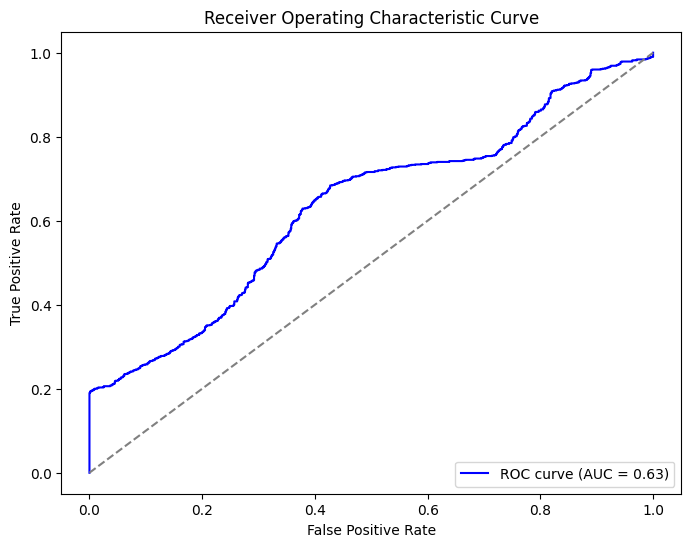

ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None

In [48]:
loss, accuracy = model1.evaluate(X_test_tsne, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
y_pred = model1.predict(X_test_tsne)
y_pred_classes = (y_pred > 0.5).astype("int32")

# Evaluate model performance
print(classification_report(y_test, y_pred_classes))
roc_auc = roc_auc_score(y_test, y_pred)
print(f"ROC-AUC: {roc_auc}")

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic Curve")
plt.legend(loc="lower right")
plt.show()

# Test Accuracy
loss, accuracy = model1.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")

# Predictions
predictions = model1.predict(X_test).flatten()
print("\n🔹 First 10 Predictions vs Actual Values 🔹")
for i in range(10):
    print(f"Sample {i+1}: Actual = {y_test[i]}, Predicted Probability = {predictions[i]:.4f}")

In [ ]:
import shap
explainer = shap.Explainer(model, X_train)
explainer = shap.GradientExplainer(model, X_train_combined[:100])
# Calculate SHAP values for the input data
shap_values = explainer(X_train)






KeyboardInterrupt: 

In [ ]:
shap.summary_plot(shap_values, input_data)

In [ ]:
shap.initjs()  # Initialize JavaScript visualization
shap.force_plot(shap_values[0], input_data[0]

In [ ]:
shap.dependence_plot("feature_name", shap_values, input_data)

In [ ]:
shap.waterfall_plot(shap_values[0])